# MLP for just the first cases

In [110]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [111]:
path = r'Results2'

In [112]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_1000.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_1000.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data <= 800
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape,freq_data.shape)


(750, 1000) (750,) (1000,)


In [113]:

#scaler = MaxAbsScaler()
#TTF_values = scaler.fit_transform(TTF_data.T).T
#print(TTF_values.shape)

def normalization(data):
    return np.log10(data)

def denormalization(data):
    return 10**data



Text(0.5, 1.0, 'TTF vs Frequency of Vs=109 m/s')

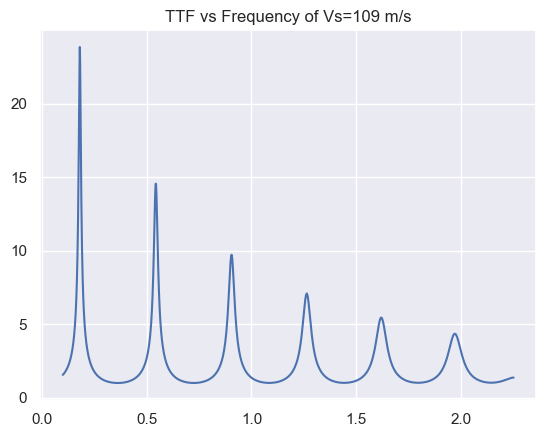

In [114]:
normalized_TTF_data = False

if normalized_TTF_data:
    TTF_values = normalization(TTF_data)
else:
    TTF_values = TTF_data

plt.plot(freq_data, TTF_values[9,:], label="TTF")
plt.title("TTF vs Frequency of Vs={:.0f} m/s".format(Vs_data[9]))

In [115]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = self.Vs_values[idx] * np.ones(30)
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

In [116]:
dataset = TTF_dataset(TTF_values, Vs_data)
print("Sizes in the dataset: ", len(dataset))
print("Data shapes for input and target: ", dataset[0][0].shape, dataset[0][1].shape)

# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Sizes in the dataset:  750
Data shapes for input and target:  torch.Size([1, 30]) torch.Size([1000])
Train, validation and test sizes:  600 75 75
Number of batches:  12 2 2


# Model

In [117]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [118]:
class CNN_1D(nn.Module):
    def __init__(self, input_size, kernel_size, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU):
        super(CNN_1D, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Conv1d(input_size, hidden_dim, kernel_size))
        self.hidden_layers.append(nn.MaxPool1d(2))

        # Additional hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Conv1d(hidden_dim, hidden_dim, kernel_size))
            self.hidden_layers.append(nn.MaxPool1d(2))

        # Adaptive pooling layer to reduce sequence length to 1
        self.hidden_layers.append(nn.AdaptiveAvgPool1d(1))

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation()(x)
        return x

In [119]:
# Let's do a RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, device="cpu"):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)   
        out = self.fc(out[:, -1, :])
        return out  

In [120]:
# Sequence-to-sequence model
# Encoder RNN
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, h1 = self.gru(x, h0)
        return out, h1

# Decoder RNN
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.rnn(x, hidden)
        return outputs, hidden

In [121]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(1)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(2, 1)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

In [122]:
class DecoderRNNWithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderRNNWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        rnn_input = torch.cat([x, context], 2)
        outputs, hidden = self.rnn(rnn_input, hidden)
        return outputs, hidden

In [123]:
# Define the Encoder LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (h1, c1) = self.lstm(x, (h0, c0))
        return out, (h1, c1)

class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, (hidden, cell) = self.lstm(x, hidden)
        return outputs, (hidden, cell)

# Define the Decoder LSTM with Attention
class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        h1, c1 = hidden
        attn_weights = self.attention(h1[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        lstm_input = torch.cat([x, context], 2)
        outputs, (hidden, cell) = self.lstm(lstm_input, hidden)
        return outputs, (hidden, cell)


In [124]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        outputs, hidden = self.gru(x)
        return outputs, hidden


class DecoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.gru(x, hidden)
        return outputs, hidden

class DecoderGRUWithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderGRUWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        gru_input = torch.cat([x, context], 2)
        outputs, hidden = self.gru(gru_input, hidden)
        return outputs, hidden

In [125]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        # Concatenate the hidden states from both directions
        hidden = self._cat_directions(hidden)
        cell = self._cat_directions(cell)
        return outputs, (hidden, cell)

    def _cat_directions(self, h):
        # [num_layers * num_directions, batch, hidden_size] -> [num_layers, batch, hidden_size * num_directions]
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
        return h

class DecoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, (hidden, cell) = self.lstm(x, hidden)
        return outputs, (hidden, cell)

In [126]:
class DecoderBiLSTMwithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderBiLSTMwithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        print("x shape: ", x.shape)
        print("hidden shape: ", hidden[0].shape)
        print("encoder_outputs shape: ", encoder_outputs.shape)
        attn_weights = self.attention(hidden[0][-1], encoder_outputs)
        print("attn_weights shape: ", attn_weights.shape)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        lstm_input = torch.cat([x, context], 2)
        outputs, hidden = self.lstm(lstm_input, hidden)
        return outputs, hidden

In [127]:
class EncoderBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderBiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        outputs, hidden = self.gru(x)
        # Concatenate the hidden states from both directions
        hidden = self._cat_directions(hidden)
        return outputs, hidden

    def _cat_directions(self, h):
        # [num_layers * num_directions, batch, hidden_size] -> [num_layers, batch, hidden_size * num_directions]
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
        return h

class DecoderBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderBiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.gru(x, hidden)
        return outputs, hidden

class DecoderBiGRUwithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderBiGRUwithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        gru_input = torch.cat([x, context], 2)
        outputs, hidden = self.gru(gru_input, hidden)
        return outputs, hidden
        

In [128]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, mlp, cnn_1d=None, cnn_1d_out=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mlp = mlp
        self.cnn_1d = cnn_1d
        self.cnn_1d_out = cnn_1d_out

    def forward(self, x, device="cpu", print_shapes=False):
        if print_shapes:
            print("Input shape: ", x.shape)

        if self.cnn_1d:
            x = self.cnn_1d(x)
            if print_shapes:
                print("CNN-in output shape: ", x.shape)
        
        encoder_outputs, hidden = self.encoder(x)
        if print_shapes:
            print("Encoder outputs shape: ", encoder_outputs.shape)
            print("Hidden state shape: ", hidden[0].shape)  # Print hidden state
            print("Cell state shape: ", hidden[1].shape)    # Print cell state
        
        # Adjust decoder input to match encoder hidden size
        if hasattr(self.encoder, 'bidirectional') and self.encoder.bidirectional:
            decoder_input_size = self.encoder.hidden_size * 2
        else:
            decoder_input_size = self.encoder.hidden_size

        decoder_input = torch.zeros(x.size(0), 1, decoder_input_size).to(device)

        if print_shapes:
            print("Decoder input shape: ", decoder_input.shape)
        
        if hasattr(self.decoder, 'attention'):
            output, hidden = self.decoder(decoder_input, hidden, encoder_outputs)
        else:
            output, hidden = self.decoder(decoder_input, hidden)
        
        if print_shapes:
            print("Decoder output shape: ", output.shape)
        
        if self.cnn_1d_out:
            output = self.cnn_1d_out(output)
            output = output.permute(0, 2, 1)
            if print_shapes:
                print("CNN-out output shape: ", output.shape)

        output = self.mlp(output)

        if print_shapes:
            print("MLP output shape: ", output.shape)
        
        return output.squeeze(1)

In [129]:
# CNN Hyperparameters - In
input_size_cnn = 1
kernel_size = 5
hidden_dim_cnn = 10
hidden_layers_cnn = 2

# CNN Hyperparameters - Out
hidden_dim_cnn_out = 10
hidden_layers_cnn_out = 1


# Encoder and Decoder hyperparameters
input_size = 1 # Given the size of [batch_size, sequence_length, input_size] 
hidden_size = 100
num_layers = 4
encoder_bidirectional = True

# MLP hyperparameters
num_layers_fc = 4
hidden_size_fc = 500
output_size = 1000

# Check bidirectional



In [130]:
# Model
cnn_1d = CNN_1D(input_size_cnn, kernel_size, hidden_dim_cnn, hidden_layers_cnn)
encoder = EncoderBiGRU(1, hidden_size, num_layers)
if hasattr(encoder, 'bidirectional') and encoder.bidirectional:
    hidden_size *= 2
decoder = DecoderBiGRUwithAttention(hidden_size, num_layers)
cnn_1d_out = CNN_1D(1, 2, hidden_dim_cnn_out, hidden_layers_cnn_out)
mlp = MLP(hidden_dim_cnn_out, hidden_size_fc, num_layers_fc, output_size)

model = Seq2Seq(encoder, decoder, mlp, cnn_1d, cnn_1d_out)

In [131]:
# Check if the model works
X, y = next(iter(train_loader))
print("Input shape: ", X.shape, "Output shape: ", y.shape)
loss_fn = nn.MSELoss()
output = model(X, print_shapes=True)
print("Model output shape: ", output.shape)
assert output.shape == y.shape, "Expected output shape to be the same as target shape"
print(loss_fn(output, y))

Input shape:  torch.Size([50, 1, 30]) Output shape:  torch.Size([50, 1000])
Input shape:  torch.Size([50, 1, 30])
CNN-in output shape:  torch.Size([50, 10, 1])
Encoder outputs shape:  torch.Size([50, 10, 200])
Hidden state shape:  torch.Size([50, 200])
Cell state shape:  torch.Size([50, 200])
Decoder input shape:  torch.Size([50, 1, 200])
Decoder output shape:  torch.Size([50, 1, 200])
CNN-out output shape:  torch.Size([50, 1, 10])
MLP output shape:  torch.Size([50, 1, 1000])
Model output shape:  torch.Size([50, 1000])
tensor(31.6669, grad_fn=<MseLossBackward0>)


In [132]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [133]:
from matplotlib.animation import FuncAnimation

def visualize_validation(model, val_loader, freq_data, example_idx=0, epoch=0):
    """
    Visualizes the model's prediction on a specific example from the validation set.

    Args:
        model: The PyTorch model being trained.
        val_loader: DataLoader for the validation dataset.
        freq_data: Frequency data for plotting the transfer function.
        example_idx: Index of the example to visualize from the validation dataset.
        epoch: Current epoch number (for display purposes).
    """
    # Get the specific example from the validation dataset
    inputs, targets = next(iter(val_loader))
    inputs, targets = inputs[example_idx], targets[example_idx]
    inputs, targets = inputs.unsqueeze(0), targets.unsqueeze(0)  # Add batch dimension

    # Move data to the same device as the model
    device = next(model.parameters()).device
    inputs, targets = inputs.to(device), targets.to(device)

    # Perform a forward pass
    model.eval()
    with torch.no_grad():
        predictions = model(inputs, device).cpu().numpy().flatten()

    # Plot the ground truth and predictions
    plt.figure(figsize=(8, 6))
    plt.plot(freq_data, targets.cpu().numpy().flatten(), label="Ground Truth", color="blue", alpha=0.7)
    plt.plot(freq_data, predictions, label="Prediction", color="red", alpha=0.7)
    plt.title(f"Validation Example (Epoch {epoch + 1})", fontsize=16)
    plt.xlabel("Frequency (Hz)", fontsize=12)
    plt.ylabel("Transfer Function", fontsize=12)
    plt.xscale("log")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.legend()
    plt.savefig(f"./Animation_Seq2Seq/validation_example_epoch_{epoch + 1}.png", dpi=300)
    plt.close()

In [134]:
from tqdm import trange, tqdm

def train_model(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", 
patience=50, clipping=True, print_epoch=10, normalize=False):
    """
    Train a PyTorch model with early stopping and learning rate scheduler.
    
    Args:
    model: PyTorch model
    optimizer: PyTorch optimizer
    scheduler: PyTorch learning rate scheduler
    train_dataloader: PyTorch DataLoader for training data
    validation_dataloader: PyTorch DataLoader for validation data
    loss_fn: PyTorch loss function
    epochs: Number of epochs to train
    device: PyTorch device, e.g. "cpu" or "cuda"
    patience: Patience for early stopping, i.e. number of epochs without improvement before stopping
    clipping: Whether to use gradient clipping
    print_epoch: Print training and validation loss every print_epoch epochs

    Returns:
    train_losses: List of training losses
    val_losses: List of validation losses
    model: Trained PyTorch model
    """
    
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X, device)
            if normalize:
                y_pred = denormalization(y_pred)
                y = denormalization(y)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X, device)
                if normalize:
                    y_pred = denormalization(y_pred)
                    y = denormalization(y)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % print_epoch == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

        # Visualize validation example every 200 epochs
        if (epoch + 1) % 200 == 0:
            visualize_validation(model, validation_dataloader, freq_data, example_idx=0, epoch=epoch)

    return train_losses, val_losses, model


def test_model(model, test_dataloader, loss_fn, device="cpu", normalize=False):
    """
    Test a PyTorch model.
    Args:
    model: PyTorch model
    test_dataloader: PyTorch DataLoader for test data
    loss_fn: PyTorch loss function
    device: PyTorch device, e.g. "cpu" or "cuda"
    Returns:
    test_loss: Average test loss
    """
    
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        if normalize:
            y_pred = denormalization(y_pred)
            y = denormalization(y)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [135]:
import torch
import torch.optim as optim
import torch.nn as nn

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4, amsgrad=True, eps=1e-08, betas=(0.9, 0.999))

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=900, 
threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)

# Training
num_epochs = 20000
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = nn.L1Loss()


Device:  cuda


In [136]:
train_losses, val_losses, model = train_model(model, optimizer, scheduler, train_loader, val_loader, loss_fn, 
epochs=num_epochs, device=device, patience=1500, clipping=True, print_epoch=1000, normalize=normalized_TTF_data)

Training:   0%|          | 0/20000 [00:00<?, ?epoch/s]

Training:   0%|          | 1/20000 [00:00<2:50:22,  1.96epoch/s]

Epoch 0, Train Loss: 2.31846692164739, Val Loss: 1.643742561340332, LR: 0.001


Training:   5%|▌         | 1001/20000 [03:47<1:50:46,  2.86epoch/s, EarlyStopping counter: 10 out of 1500]

Epoch 1000, Train Loss: 0.6301287710666656, Val Loss: 0.5775920748710632, LR: 0.001


Training:  10%|█         | 2001/20000 [07:33<1:35:16,  3.15epoch/s, EarlyStopping counter: 145 out of 1500]

Epoch 2000, Train Loss: 0.37771229445934296, Val Loss: 0.4303518980741501, LR: 0.001


Training:  15%|█▌        | 3001/20000 [11:22<1:32:35,  3.06epoch/s, EarlyStopping counter: 48 out of 1500] 

Epoch 3000, Train Loss: 0.31744333108266193, Val Loss: 0.36544013023376465, LR: 0.001


Training:  20%|██        | 4001/20000 [15:17<1:22:14,  3.24epoch/s, EarlyStopping counter: 347 out of 1500]

Epoch 4000, Train Loss: 0.3812981868783633, Val Loss: 0.370348259806633, LR: 0.001


Training:  25%|██▌       | 5001/20000 [30:17<5:08:12,  1.23s/epoch, EarlyStopping counter: 185 out of 1500]

Epoch 5000, Train Loss: 0.2545318379998207, Val Loss: 0.3128243237733841, LR: 0.001


Training:  30%|███       | 6001/20000 [45:16<1:18:07,  2.99epoch/s, EarlyStopping counter: 47 out of 1500] 

Epoch 6000, Train Loss: 0.3065364621579647, Val Loss: 0.3931678980588913, LR: 0.001


Training:  35%|███▌      | 7001/20000 [59:29<4:23:31,  1.22s/epoch, EarlyStopping counter: 371 out of 1500]

Epoch 7000, Train Loss: 0.22503932689627013, Val Loss: 0.2704460620880127, LR: 0.001


Training:  40%|████      | 8001/20000 [1:07:32<1:03:10,  3.17epoch/s, EarlyStopping counter: 163 out of 1500]

Epoch 8000, Train Loss: 0.18210299561421076, Val Loss: 0.22764941304922104, LR: 0.001


Training:  45%|████▌     | 9001/20000 [1:11:11<53:28,  3.43epoch/s, EarlyStopping counter: 402 out of 1500]  

Epoch 9000, Train Loss: 0.29398873820900917, Val Loss: 0.2915305197238922, LR: 0.001


Training:  50%|█████     | 10001/20000 [1:15:00<1:02:39,  2.66epoch/s, EarlyStopping counter: 264 out of 1500]

Epoch 10000, Train Loss: 0.17278975372513136, Val Loss: 0.2625620737671852, LR: 0.0005


Training:  55%|█████▌    | 11001/20000 [1:21:43<2:10:12,  1.15epoch/s, EarlyStopping counter: 613 out of 1500]

Epoch 11000, Train Loss: 0.1695209083457788, Val Loss: 0.24629585444927216, LR: 0.0005


Training:  60%|██████    | 12001/20000 [1:32:14<1:42:30,  1.30epoch/s, EarlyStopping counter: 787 out of 1500]

Epoch 12000, Train Loss: 0.14208505054314932, Val Loss: 0.19085883349180222, LR: 0.0005


Training:  65%|██████▌   | 13001/20000 [1:38:55<1:35:09,  1.23epoch/s, EarlyStopping counter: 476 out of 1500]

Epoch 13000, Train Loss: 0.18608973547816277, Val Loss: 0.24268771708011627, LR: 0.0005


Training:  70%|███████   | 14001/20000 [1:59:47<48:07,  2.08epoch/s, EarlyStopping counter: 636 out of 1500]    

Epoch 14000, Train Loss: 0.13853581373890242, Val Loss: 0.2117273285984993, LR: 0.0005


Training:  75%|███████▌  | 15001/20000 [2:05:05<37:49,  2.20epoch/s, EarlyStopping counter: 68 out of 1500] 

Epoch 15000, Train Loss: 0.13915036184092364, Val Loss: 0.27395133674144745, LR: 0.0005


Training:  80%|████████  | 16001/20000 [2:10:24<32:01,  2.08epoch/s, EarlyStopping counter: 114 out of 1500]

Epoch 16000, Train Loss: 0.12238695720831554, Val Loss: 0.18328192830085754, LR: 0.00025


Training:  85%|████████▌ | 17001/20000 [2:15:35<24:18,  2.06epoch/s, EarlyStopping counter: 221 out of 1500]

Epoch 17000, Train Loss: 0.10978680290281773, Val Loss: 0.16643456369638443, LR: 0.00025


Training:  90%|█████████ | 18001/20000 [2:20:18<10:24,  3.20epoch/s, EarlyStopping counter: 62 out of 1500] 

Epoch 18000, Train Loss: 0.12483380486567815, Val Loss: 0.17913655936717987, LR: 0.000125


Training:  95%|█████████▌| 19001/20000 [2:24:02<04:55,  3.38epoch/s, EarlyStopping counter: 383 out of 1500]

Epoch 19000, Train Loss: 0.10051074748237927, Val Loss: 0.1529623121023178, LR: 0.000125


Training: 100%|██████████| 20000/20000 [2:29:56<00:00,  2.22epoch/s, EarlyStopping counter: 169 out of 1500]


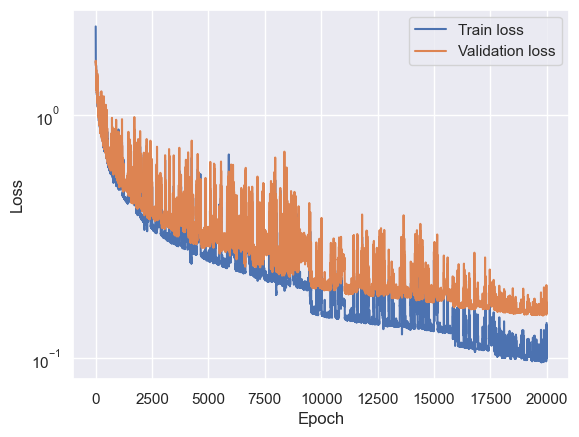

In [153]:
# Plot losses
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [154]:
# Test model    
test_loss = test_model(model, test_loader, loss_fn, device=device, normalize=normalized_TTF_data)
print("Test loss: ", test_loss)

Test loss:  0.1760285422205925


In [155]:
# Show results
model.eval()
target = []
predicted = []
Vs_data = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        target.append(y.cpu().numpy())
        predicted.append(y_pred.cpu().numpy())
        Vs_data.append(X.cpu().numpy())

target = np.concatenate(target)
predicted = np.concatenate(predicted)
Vs_data = np.concatenate(Vs_data)

# Undo log transformation
if normalized_TTF_data:
    target = denormalization(target)
    predicted = denormalization(predicted)

print(target.shape, predicted.shape, Vs_data.shape)

(75, 1000) (75, 1000) (75, 1, 30)


In [156]:
# Get the correlation factor between target and predicted
from scipy.stats import pearsonr

for i in range(target.shape[0]):
    print("Correlation factor for TTF ", i,"and Vs ", str(Vs_data[i,0,0]), " : ", pearsonr(target[i], predicted[i])[0])

Correlation factor for TTF  0 and Vs  260.628  :  0.929904644832547
Correlation factor for TTF  1 and Vs  558.278  :  0.9984155405088098
Correlation factor for TTF  2 and Vs  150.668  :  0.9911422966041314
Correlation factor for TTF  3 and Vs  238.825  :  0.9871962581635225
Correlation factor for TTF  4 and Vs  683.405  :  0.999158158472756
Correlation factor for TTF  5 and Vs  227.45  :  0.9591037131817766
Correlation factor for TTF  6 and Vs  674.873  :  0.998688880001634
Correlation factor for TTF  7 and Vs  139.292  :  0.9189525732683563
Correlation factor for TTF  8 and Vs  106.115  :  0.9742919815499764
Correlation factor for TTF  9 and Vs  217.023  :  0.9825442891462544
Correlation factor for TTF  10 and Vs  744.072  :  0.9992212470103855
Correlation factor for TTF  11 and Vs  662.55  :  0.9988141395621896
Correlation factor for TTF  12 and Vs  526.048  :  0.9912830649085066
Correlation factor for TTF  13 and Vs  557.33  :  0.9987609296808732
Correlation factor for TTF  14 and V

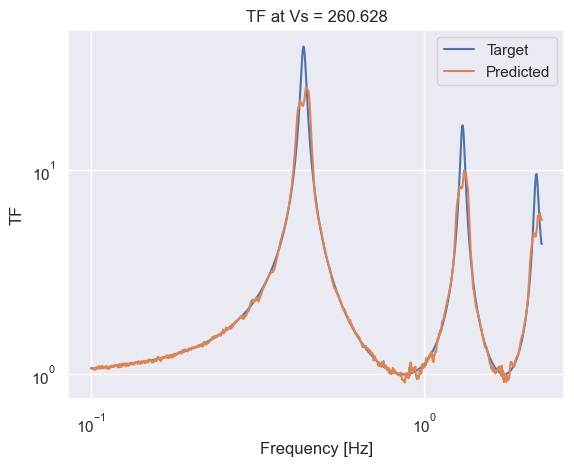

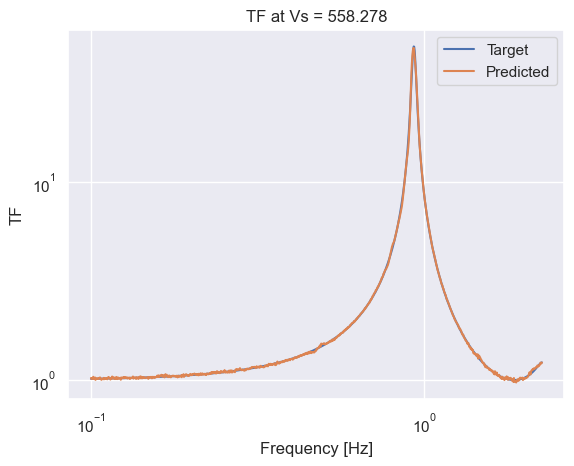

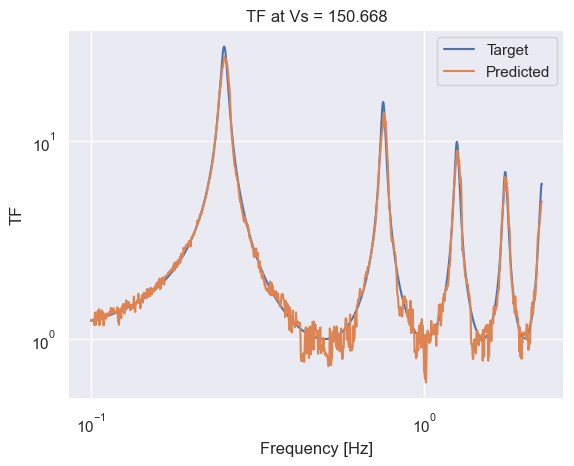

In [157]:
for i in range(target.shape[0]):
    plt.loglog(freq_data, target[i,:], label="Target")
    plt.loglog(freq_data, predicted[i,:], label="Predicted")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TF")
    plt.title("TF at Vs = " + str(Vs_data[i,0,0]))
    plt.legend()
    plt.show()

    if i == 2:
        break

# Checking

In [158]:
# Create a lodaer for the whole dataset
all_loader = DataLoader(dataset, batch_size=1, shuffle=False)

correlations = []
Vs_range = []
predicted = []
target = []

with torch.no_grad():
    for X, y in all_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        if normalized_TTF_data:
            y_pred = denormalization(y_pred)
            y = denormalization(y)
        correlations.append(pearsonr(y.cpu().numpy().flatten(), y_pred.cpu().numpy().flatten())[0])
        Vs_range.append(X.cpu().numpy().flatten()[0])
        predicted.append(y_pred.cpu().numpy().squeeze())
        target.append(y.cpu().numpy().squeeze())

correlations = np.array(correlations)
Vs_range = np.array(Vs_range)
predicted = np.array(predicted)
target = np.array(target)

print(correlations.shape, Vs_range.shape, predicted.shape, target.shape)



(750,) (750,) (750, 1000) (750, 1000)


In [159]:
X.shape

torch.Size([1, 1, 30])

In [160]:
# Save correlation results

np.savetxt(os.path.join(path,"correlations_try_1.csv"), correlations, delimiter=",")
np.savetxt(os.path.join(path,"Vs_pred_try_1.csv"), predicted, delimiter=",")

np.savetxt(os.path.join(path, "Vs_range_try_1.csv"), Vs_range, delimiter=",")
np.savetxt(os.path.join(path, "TTF_target_try_1.csv"), target, delimiter=",")

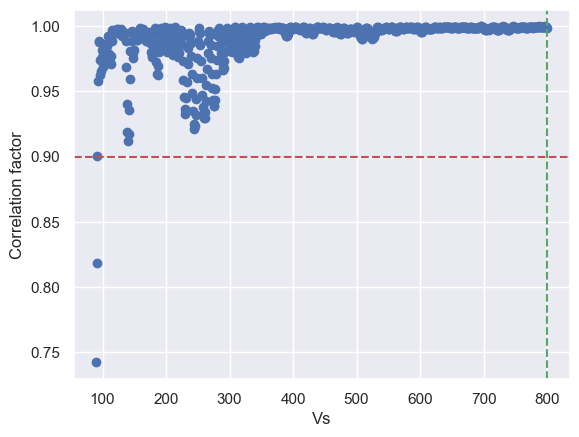

In [161]:
plt.scatter(Vs_range,correlations)
plt.xlabel("Vs")
plt.ylabel("Correlation factor")

# Add horizontal line at 0.9
plt.axhline(y=0.9, color='r', linestyle='--')

# Add vertical transparency after VS = 800
plt.axvline(x=800, color='g', linestyle='--')

#plt.yscale("log")
plt.show()

In [162]:
Vs_range[np.abs(Vs_range - 181.764).argmin()]

181.949

In [163]:
Vs_range.shape

(750,)

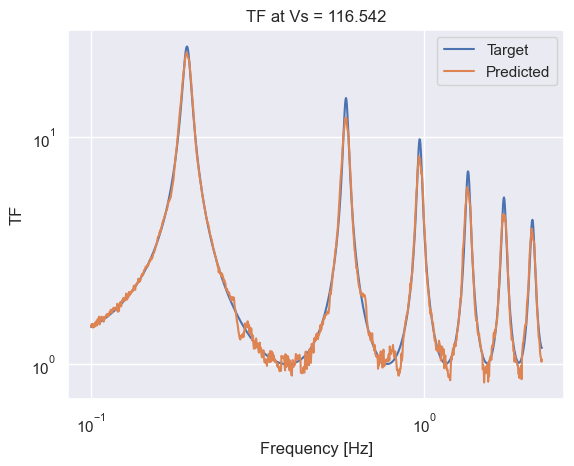

In [164]:
# Plot predicted
for i in range(predicted.shape[0]):

    if Vs_range[i] in [100, Vs_range[17]]:
        plt.loglog(freq_data, target[i,:], label="Target")
        plt.loglog(freq_data, predicted[i,:], label="Predicted")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("TF")
        plt.title("TF at Vs = " + str(Vs_range[i]))
        plt.legend()
        plt.show()

In [165]:
# Save model
#torch.save(model.state_dict(), os.path.join(r"FLAC\FLAC2D\1D 1 Column\model_save","model_CNN_RNN_1000.pt"))

In [150]:
# Save model
torch.save(model.state_dict(),"model_CNN_RNN_1000.pt")

In [151]:
model_2 = Seq2Seq(encoder, decoder, mlp, cnn_1d, cnn_1d_out)

model_2.load_state_dict(torch.load("model_CNN_RNN_1000.pt"))

C:\Users\kurt-\AppData\Local\Temp\ipykernel_29388\3666410171.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2.load_state_dict(torch.load("model_CNN_RNN_1000.pt"))

<All keys matched successfully>

In [166]:
import imageio
import os
import re

def create_gif_from_validation_images(image_folder, output_gif_path, duration=0.5):
    """
    Creates a GIF animation from saved validation example images.

    Args:
        image_folder (str): Path to the folder containing the saved validation images.
        output_gif_path (str): Path to save the output GIF file.
        duration (float): Duration of each frame in the GIF (in seconds).
    """
    # Get all image file paths in the folder
    image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".png")]

    # Extract epoch numbers using regex and sort the files
    image_files = sorted(image_files, key=lambda x: int(re.search(r'epoch_(\d+)', x).group(1)))

    # Read images and create the GIF
    with imageio.get_writer(output_gif_path, mode="I", duration=duration) as writer:
        for image_file in image_files:
            image = imageio.imread(image_file)
            writer.append_data(image)

    print(f"GIF saved at {output_gif_path}")


# Example usage
# Assuming validation images are saved in "./Animation" folder
create_gif_from_validation_images(image_folder="./Animation_Seq2Seq", output_gif_path="validation_animation.gif", duration=0.5)

C:\Users\kurt-\AppData\Local\Temp\ipykernel_29388\357498476.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_file)


GIF saved at validation_animation.gif
